# Pre Start (Imports and Funcs)

In [652]:
import numpy as np
import matplotlib.pyplot as plt

In [653]:
L = 1

def u0(x):
    return x * (x + 1)

def u2(t):
    return u0(L) * np.cos(np.pi * t)

def u(t, x):
    return u0(x) * np.cos(np.pi * t)

def F(t, x):
    return -np.cos(np.pi * t) * (np.pi**2 * x * (x + 1) + 2)

# Dots for x and t

In [654]:
x_limits = [0, L]
t_limits = [0, 2]
nx = 100
nt = 1_000_00#0

u1 = 0

x = np.linspace(*x_limits, nx)
dx = x[1] - x[0]
t = np.linspace(*t_limits, nt)
dt = t[1] - t[0]
diff = dt/ dx**2
print("dt/dx**2 = ", diff)
assert diff <= .5, f"Нестійкість! {diff}"


dt/dx**2 =  0.19602196021960216


# Main Part

$$ u(i, k+1) = 2 \cdot u(i, k) - u(i, k-1) + \Delta{t}^2 \cdot \left( \frac{u(i+1, k) - 2 \cdot u(i, k) + u(i-1, k)}{\Delta{x}^2} + F(i, k)\right) $$


$$ u(t,0) = 0 \cdot 1 \cdot \cos(\pi \cdot t) = 0 $$
$$ u(t, L) = L \cdot (L+1) \cdot \cos(\pi \cdot t) = 1 \cdot 2 \cdot \cos(\pi \cdot t) = 2 \cdot \cos(\pi \cdot t) $$

In [655]:
U = np.zeros((nt, nx), dtype=float)
U[:, 0] = u1
U[:, -1] = u2(t)
U[0, :] = u0(x)

In [656]:
for k in range(1, nx - 1):
    U[1:-1, k] = 2 * U[1:-1, k-1] - U[1:-1, k-2] + dt**2 * ((U[2:, k-1] - 2 * U[1:-1, k-1] + U[:-2, k-1]) / dx**2 + F(t[1:-1], x[k]))

In [657]:
# Uc = U.copy()
# for k in range(1, nx - 1):
#     for i in range(1, nt - 1):
#         Uc[i, k] = 2 * Uc[i, k-1] - Uc[i, k-2] + dt**2 * ((Uc[i+1, k-1] - 2 * Uc[i, k-1] + Uc[i-1, k-1]) / dx**2 + F(t[i], x[k]))
# (Uc == U).all()

<function matplotlib.pyplot.show(close=None, block=None)>

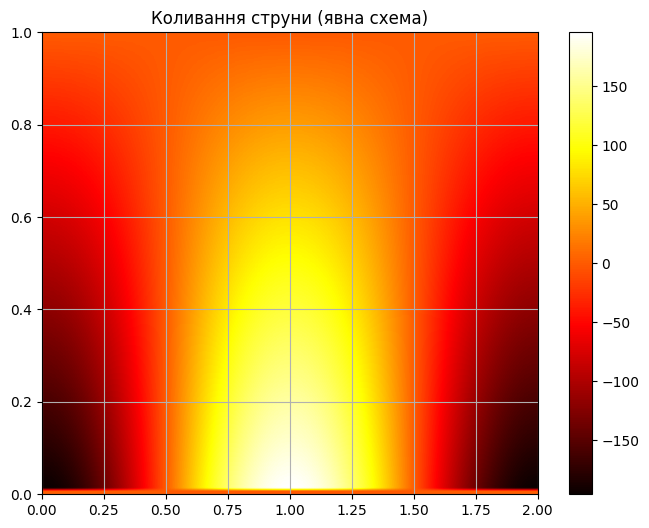

In [662]:
fig, ax = plt.subplots(figsize=(8, 6))
colorbar = ax.imshow(U[:, ::-1].T, cmap="hot", aspect="auto", extent=[t[0], t[-1], x[0], x[-1]], origin="lower")
# colorbar = ax.imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(colorbar, ax=ax)

# y_plot_1 = (U[1] - U.min()) / (U.max() - U.min()) * t[-1]
# y_plot_n1 = (U[-2] - U.min()) / (U.max() - U.min()) * t[-1]
# ax.plot(x, y_plot_1, label=f"t = {t[1]}")
# ax.plot(x, y_plot_n1, label=f"t = {t[-2]}")
# ax.legend()

ax.set_title("Коливання струни (явна схема)")
ax.grid(True)
plt.show